In [1]:
%matplotlib inline
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import constants, core

Some notes on the implementation:
1. Radius makes linearly spaces points from $r_cmb$ ($=3480$, fixed position) to $r_t$ (top of BMO, changes in time)
2. I choose $Ta$ s.t. $dT_a/dr \propto T_a$:  
$$T_a = T_a(r_t)[1-\gamma_a(r-r_t)]$$ 
3. I choose $T_l$ so it is similar to Williams & Nimmo 2004: 
$$T_l = (T_l(r_t) - \gamma_c c) [1-\gamma_m(r-r_t)]$$ 
4. $dc/dt$ and $da/dt$ are calculated according to the Gubbins formulation, which is similar to your notes. This means $dc/dt$ is given by the same eqn as in Labrosse, though I have for now assumed there is no impurity in the solid phase so his $\Delta c \rightarrow c_l$. Its worth checking the sign of $da/dt$
5. I don't think $T_a(r_t) = T_l(r_t)$ with this formulation owing to the factor $-\gamma_c c$ (See plot below). We could add a small correction to $Ta$ to make this so but I haven't done it yet

In [2]:
beta  = 1.0/3.0
k     = 8
delta = 100e3
nu    = 1e10
cp    = 1000
ds    = 300.0
cp_core = 860
rhom    = 5500
M_core  = 2e24
gamma_a = 5.0e-7
gamma_c = 1
gamma_m = 0.9e-7
eta     = 0.7

def adiabat(Ta_t, r, N):
    Ta    =  Ta_t * (1 - gamma_a*(r - r[N-1]))
    dTadr = -Ta_t * gamma_a
    return Ta, dTadr
    
def melting(Tl_t,c,r,N):
    Tl    = (Tl_t - gamma_c*c) * (1 - gamma_m * (r - r[N-1]) )
    dTldr =-(Tl_t - gamma_c*c) * gamma_m 
    return Tl, dTldr
    
def mass(r_l,r_t):
    Mbmo = 4.0 * math.pi * rhom * (r_t**3 - r_l**3 ) / 3
    return Mbmo
    
def latent_coeff(Tl):
    L = Tl*ds
    return L
        
def latent(r_t,L,fac):
    """This is Gubbins et al 03 eqn 33 with the factor calculated from dadt_fac below"""
    Ql = -4 *math.pi *r_t**2 * L * rhom * fac
    return Ql

def latent_labrosse(r_l,r_t,L,cl,cs):
    dT = 3500-5500
    num = 4 * math.pi * rhom * L * (r_t**3 - r_l**3)
    den = 3 * (cl-cs) * dT
    return num/den
    
def radioactivity(h0,t,Mbmo):
#    h = h0 * 2**(-t/hl_Ur238)
    Qr = 20e12 * np.exp(-t/3e9)
    return Qr
    
def Tm_init(r_t,Tl):
    Qbmo_init = 30e12
    fac = Qbmo_init*delta / (4*math.pi*k*r_t**2)
    return Tl - fac
    
def bmo_flux(r_t,Tl,Tm,deltaT):
    """Set Tm to the value needed to get 30TW of flux at time 0 when the BMO was 1000 km thick"""
    Qbmo = 4 * math.pi * r_t**2 * k * (Tl-Tm) / delta
    return Qbmo
    
def cmb_flux(A, T_c, Tl_m):
    deltaT = T_c - Tl_m

    if(deltaT < 0.0): 
        sys.exit('BMO is hotter than CMB! deltaT**(1+beta) will fail. Maybe dTa/dr is too steep? Exiting...')
    
    Qcmb   = A * deltaT**(1+beta) * nu**(-beta)
    return Qcmb
    
def cmb_flux_labrosse():
    Mc = -cp_core*M_core
    return Mc

def heat_of_reaction(i):
    Rh = 3e5
    Qh = 4*math.pi*constants.r_cmb**2 * i
    return Qh

def cmb_flux_mass():
    """Ideally I would consider a BMO of uniform composition, cb; then cb determines 
    the core composition cc. However, there will be a thin diffusive layer above the 
    core that accommodates the mass transfer"""
    
def dcdt_fac_labrosse(r_l,r_t,cl,cs):
    num = 3 * r_t**2 * (cl-cs)
    den = r_t**3 - r_l**3
    return -num/den
    
def dadt_fac_labrosse(r_l,r_t,cl,cs):
    dT = 3500-5500
    num = r_t**3 - r_l**3
    den = 3 * r_t**2 * (cl-cs) * dT
    return num/den

def dcdt_fac(r_t, cl, Mbmo, drdt):
    fac = -4*np.pi*r_t**2 * rhom * cl / Mbmo * drdt
    return fac

def dadt_fac(dTadr, dTmdr): 
    """This is equation 25 of Gubbins et al 03, but in terms of dTdr rather than dT/dp. 
    Also I took the factor Ti/Tc = 1 as we are evaluating at the top, i.e. at Tc. """
    fac = 1 / (dTldr -dTadr)
    return fac

def cool():
    print(Ta_l)
    Qcmb[i]  = cmb_flux(A,Ta_c,Ta_l)
    QL_fac   = latent(r_t,L,dadt_fac(dTadr,dTldr))
    dTldt    = (Qbmo[i] - Qrbmo[i] - Qcmb[i]) / (-Mbmo*cp + QL_fac) 
    Qsbmo[i] =-Mbmo*cp *dTldt
    QLbmo[i] = QL_fac  *dTldt  
    drtdt    = dadt_fac(dTadr,dTldr)*dTldt
    
    if(i==nt/2): 
        print("Getting a sample for visualisation Ta at n = ", i)
        Ta_test=Ta
        Tl_test=Tl
        r_test=r
    
    return dTldt, drtdt    

def cool_labrosse():  
    Qcmb_fac = cmb_flux_labrosse()
    QL_fac   = latent_labrosse(rc,r_t,L,cl,cs)
    dTldt    = (Qbmo[i] - Qrbmo[i]) / (-Mbmo*cp + QL_fac + Qcmb_fac)
    Qcmb[i]  = Qcmb_fac*dTldt
    Qsbmo[i] =-Mbmo*cp *dTldt
    QLbmo[i] = QL_fac  *dTldt    
    drtdt    = dadt_fac_labrosse(rc,r_t,cl,cs)*dTldt
    return dTldt, drtdt


In [3]:
Nb=100
nt = int((constants.te-constants.ts)/constants.dt)+1
zero = np.zeros(nt)
Qbmo, Qcmb, Qsbmo, Qrbmo, QLbmo   = zero, zero, zero, zero, zero
Qcmb   = np.zeros(nt)
Qsbmo  = np.zeros(nt)
Qrbmo  = np.zeros(nt)
QLbmo  = np.zeros(nt)
tim    = np.zeros(nt)
r_top   = np.zeros(nt)
T_top  = np.zeros(nt)

Qrman = np.zeros(nt)

Ta = np.zeros(Nb)
Tl = np.zeros(Nb)
Ta_test = np.zeros(Nb)
Tl_test = np.zeros(Nb)
r_test = np.zeros(Nb)

"""Initial values"""
r_t  = 3880e3
Tl_t = 4700
Ta_c = 6000
A    = 1e12
cl   = 0.088
cs   = 0.0
rc   = constants.r_cmb

"""Initial mass of the mantle"""
Mbmo = mass(rc,r_t)
h0   = 20e12/Mbmo
Tm   = Tm_init(r_t,Tl_t)
deltaT_lm = Tl_t - Tm

for i in range (1,nt):

    """------------------------------------------"""
    """These bits are not needed for Labrosse BMO"""
    r  = constants.radius(rc,r_t,Nb)
    [Ta,dTadr] = adiabat(Tl_t,r,Nb)
    [Tl,dTldr] = melting(Tl_t,cl,r,Nb)
    Ta_l       = Ta[int(1)]
    """------------------------------------------"""
    
    tim[i] = constants.ts + constants.dt*i
    L      = latent_coeff(Tl_t)
    Mbmo   = mass(rc,r_t)
 
    Qbmo[i]      = bmo_flux(r_t,Tl_t,Tm,deltaT_lm)
    Qrbmo[i]     = radioactivity(h0,tim[i],Mbmo) 
    dTldt, drtdt = cool_labrosse()
    
    EJ, dTcdt    = core.cool_core(Qcmb[i], Tl_t)
    print(EJ/1e6,dTcdt*constants.secinyr*1e9)
    
    r_t   = r_t  - drtdt*constants.dt*constants.secinyr #- for Labrosse; + for me
    Tl_t  = Tl_t + dTldt*constants.dt*constants.secinyr
        
    r_top[i] = r_t
    T_top[i] = Tl_t
    
    """These bits are new for our model. Note that I set the core cooling rate to 
    be a fraction of the bmo cooling rate on the last line. I chhse the value to 
    a similar evolution of Qcmb to Labrosse. 
    A key difference is that Qcmb does not contribute to the cooling aret any more."""
    # NOTE - cl here is FeO. We need Fe, but this is OK as there is 1 mol Fe in FeO. 
    #dcdt = dcdt_fac(r_t, cl, Mbmo, drtdt)
    #cl   = cl   + dcdt     *constants.dt*constants.secinyr
    #Ta_c = Ta_c + 0.3*dTldt*constants.dt*constants.secinyr
                            
    if(r_t < rc): 
        sys.exit("BMO has gone!", "r_cmb, r_t = ", rc, r_t)        


divid by zero
-372.804221773 -54.6143015225
divid by zero
-372.474579531 -54.7824438847
divid by zero
-372.144784687 -54.9506320148
divid by zero
-371.814834496 -55.1188672198
divid by zero
-371.484726218 -55.2871508024
divid by zero
-371.154457124 -55.4554840606
divid by zero
-370.824024489 -55.6238682883
divid by zero
-370.493425597 -55.7923047749
divid by zero
-370.162657739 -55.9607948056
divid by zero
-369.831718212 -56.1293396609
divid by zero
-369.500604323 -56.2979406172
divid by zero
-369.169313382 -56.4665989465
divid by zero
-368.837842709 -56.6353159165
divid by zero
-368.506189631 -56.8040927906
divid by zero
-368.174351482 -56.9729308276
divid by zero
-367.842325602 -57.1418312823
divid by zero
-367.510109338 -57.3107954051
divid by zero
-367.177700046 -57.479824442
divid by zero
-366.845095087 -57.6489196348
divid by zero
-366.512291831 -57.8180822209
divid by zero
-366.179287653 -57.9873134336
divid by zero
-365.846079935 -58.1566145017
divid by zero
-365.512666069 -58.

C:\Users\earcd\Desktop\core.py:32: RuntimeWarning: invalid value encountered in true_divide
  g   = 4*np.pi*GG*ans/r**2


-77.215622121 -178.889902701
divid by zero
-77.2131622546 -178.846046818
divid by zero
-77.2115082202 -178.801841567
divid by zero
-77.2106569377 -178.757288684
divid by zero
-77.2106053343 -178.712389897
divid by zero
-77.2113503452 -178.667146931
divid by zero
-77.212888913 -178.621561502
divid by zero
-77.2152179885 -178.575635325
divid by zero
-77.2183345301 -178.529370106
divid by zero
-77.2222355042 -178.482767548
divid by zero
-77.2269178851 -178.435829347
divid by zero
-77.232378655 -178.388557194
divid by zero
-77.2386148045 -178.340952774
divid by zero
-77.245623332 -178.293017768


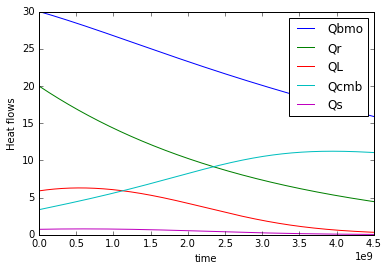

In [4]:
plt.plot(tim,Qbmo/1e12,label="Qbmo")
plt.plot(tim,Qrbmo/1e12,label="Qr")
plt.plot(tim,QLbmo/1e12,label="QL")
plt.plot(tim,Qcmb/1e12,label="Qcmb")
plt.plot(tim,Qsbmo/1e12,label="Qs")
plt.xlabel('time')
plt.ylabel('Heat flows')
plt.legend()
plt.show()

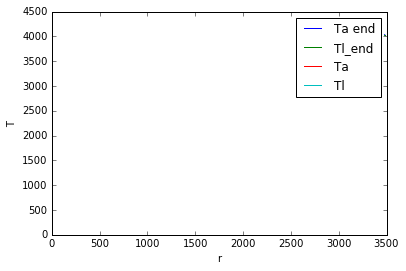

In [5]:
plt.plot(r/1e3, Ta, label="Ta end")
plt.plot(r/1e3, Tl, label="Tl_end")
plt.plot(r_test/1e3, Ta_test, label="Ta")
plt.plot(r_test/1e3, Tl_test, label="Tl")
plt.xlabel('r')
plt.ylabel('T')
plt.legend()
plt.show()

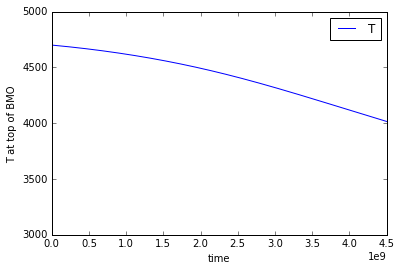

In [6]:
plt.plot(tim,T_top,label="T")
plt.ylim((3000,5000))
plt.xlabel('time')
plt.ylabel('T at top of BMO')
plt.legend()
plt.show()

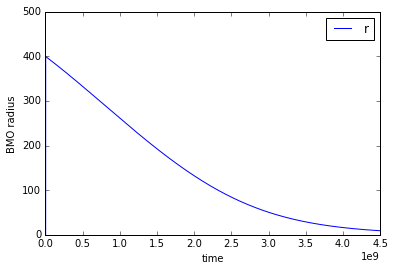

In [7]:
plt.plot(tim,(r_top-rc)/1e3,label="r")
plt.ylim((0,500))
plt.xlabel('time')
plt.ylabel('BMO radius')
plt.legend()
plt.show()

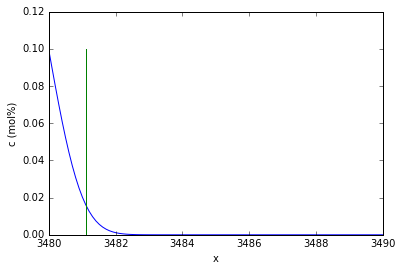

In [51]:
"""Test the erf approximation for the base of the BMO"""
time = 1e6*constants.secinyr
D    = 1e-8

# Diffusion lengthscale 
h   =2.0*np.sqrt(D*time)
hy  = [0, 0.1]

x = constants.radius(3480e3,3490e3,Nb)

hvec=h*np.ones(Nb)
cvec=3480e3*np.ones(Nb)
xmod=(x-cvec)
zeta=xmod/hvec
c_top = 0.1

conc = c_top * scipy.special.erfc(zeta)

plt.plot(x/1e3,conc)
plt.plot([3480+h/1e3,3480+h/1e3], hy)
plt.xlabel('x')
plt.ylabel('c (mol%)')
#plt.xlim([3480, 3600])
plt.show()